# How would Height of the basketball player affect the force it takes to make a free throw?

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

Fm = S (w × v)

In [2]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
degree = UNITS.degree
rad = UNITS.radian

<Unit('radian')>

In [3]:

params = Params(x = 0 * m,                   # x coordinate of the basketball
                y = 0 * m,                   # y coordinate of the basketball
                omega = 6 * np.pi * rad / s ** 2,    # angular velocity
                rho = 1.2 * kg / m ** 3,     # mass density of the fluid
                C_d = 0.54,                  # drag coefficient of a basketball
                x_dist = 4.9 * m,            # horizontal distance of player to net
                y_dist = 3.05 * m,           # distance of the rim from ground
                v = 0 * m / s,               # velocity of the basketball
                S = 0.47,                    # air resistance coefficient of spheres
                g = 9.8 * m/s**2,            # gravity
                angle = 52 * degree,         # launch angle of the basketball
                mass = 0.625 * kg,           # mass of the basketball
                diameter = 0.23 * m,         # diameter of the basketball
                radius = 0.115 * m,          # radius of the basketball
                t_end = 10 * s)

,values
x,0 meter
y,0 meter
omega,18.84955592153876 radian / second ** 2
rho,1.2 kilogram / meter ** 3
C_d,0.54
x_dist,4.9 meter
y_dist,3.05 meter
v,0.0 meter / second
S,0.47
g,9.8 meter / second ** 2


In [4]:
def make_system(params, v_0, height):
    """Make a system object.
    
    params: 
    
    returns: System object
    """
    unpack(params)
     # convert angle to degrees
    theta = np.deg2rad(angle)
    
    
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, v_0)
  
    init = State(x = x, y = height, vx = vx, vy = vy)

    # compute area from diameter
    area = np.pi * (diameter/2)**2
    
    return System(params, init=init, area = area)

In [5]:
system = make_system(params, 0 * m / s, 1.8 * m)

,values
x,0 meter
y,0 meter
omega,18.84955592153876 radian / second ** 2
rho,1.2 kilogram / meter ** 3
C_d,0.54
x_dist,4.9 meter
y_dist,3.05 meter
v,0.0 meter / second
S,0.47
g,9.8 meter / second ** 2


In [6]:
def drag_force(V, system):
    """Computes drag force in the opposite direction of `V`.
    
    V: velocity
    system: System object with rho, C_d, area
    
    returns: Vector drag force
    """
    unpack(system)
    mag = -rho * V.mag**2 * C_d * area / 2
    direction = V.hat()
    #direction is that of velocity
    f_drag = mag * direction
    return f_drag

In [7]:
def magnus_force(V,system):
    """Computes drag force in the opposite direction of `V`.
    
    V: velocity
    system: System object with rho, C_d, area
    
    returns: Vector drag force
    """
    unpack(system)
    magnitude = 16/3 * np.pi**2 * radius**3 * rho
    f_magnus = magnitude * np.cross(Vector(0,omega).hat(),V.hat()) 
    #direction is the cross product of the direction of omega and velocity
    return f_magnus

In [8]:
def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, vx, vy = state
    unpack(system)

    V = Vector(vx, vy)
    a_drag = drag_force(V, system) / mass
    a_grav = Vector(0, -g)
    a_magnus = magnus_force(V,system)/ mass
    
    a = a_grav + a_drag - a_magnus
    #magnus force has an acceleration in direction opposite of gravitation and drag
    
    return vx, vy, a.x, a.y

In [9]:
def event_func(state, t, system):
    """Stop when the y coordinate is 0.
    
    state: State object
    t: time
    system: System object
    
    returns: y coordinate
    """
    x, y, vx, vy = state
    return x - 4.9 
    #stops when the x position is that of the basket

In [10]:
def height_func(v_0, height):
    system = make_system(params, v_0 = v_0, height = height)
    results, details = run_ode_solver(system, slope_func, events=event_func)
    return Vector(get_last_value(results.x) * m, get_last_value(results.y) * m)

In [11]:
height_func(20 * m /s, 1.8*  m)

<Quantity([4.9       7.2039358], 'meter')>

In [12]:
velocities = linspace(6,12,100)
#creates an array of velocities that is within the expected range
heights = linspace(1.6, 2.3, 10)
#creates an array of heights from shortest to tallest player
sweep_h = SweepSeries()

print(heights)
# runs through the height array and the velocity array 
# to find minimum initially velocity required to make a basket
for h in heights: 
    sweep_v = SweepSeries()
    for vel in velocities:
        vector = height_func(vel * m / s, h * m)
        if(vector.y.mag < 3.165 * m and vector.y.mag > 2.935 * m):
            print(h, vel, vector)
            sweep_v[vel] = vector
            break
    sweep_h[h] = sweep_v.index[0]
sweep_h

[1.6        1.67777778 1.75555556 1.83333333 1.91111111 1.98888889
 2.06666667 2.14444444 2.22222222 2.3       ]
1.6 8.242424242424242 [4.9        2.96214645] meter
1.6777777777777778 8.181818181818182 [4.9        2.96976454] meter
1.7555555555555555 8.121212121212121 [4.9        2.97585683] meter
1.8333333333333333 8.06060606060606 [4.9        2.98037896] meter
1.911111111111111 8.0 [4.9        2.98328504] meter
1.988888888888889 7.9393939393939394 [4.9        2.98452753] meter
2.0666666666666664 7.878787878787879 [4.9        2.98405712] meter
2.1444444444444444 7.818181818181818 [4.9        2.98182258] meter
2.2222222222222223 7.757575757575758 [4.9        2.97777061] meter
2.3 7.696969696969697 [4.9        2.97184568] meter


,values
1.600000,8.242424
1.677778,8.181818
1.755556,8.121212
1.833333,8.060606
1.911111,8.000000
1.988889,7.939394
2.066667,7.878788
2.144444,7.818182
2.222222,7.757576
2.300000,7.696970


In [13]:
sweep_h.index

Float64Index([               1.6, 1.6777777777777778, 1.7555555555555555,
              1.8333333333333333,  1.911111111111111,  1.988888888888889,
              2.0666666666666664, 2.1444444444444444, 2.2222222222222223,
                             2.3],
             dtype='float64')

In [14]:
sweep_h

,values
1.600000,8.242424
1.677778,8.181818
1.755556,8.121212
1.833333,8.060606
1.911111,8.000000
1.988889,7.939394
2.066667,7.878788
2.144444,7.818182
2.222222,7.757576
2.300000,7.696970


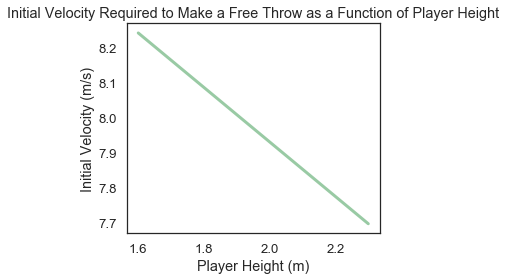

In [15]:
plot(sweep_h, color='C2')
decorate(xlabel='Player Height (m)',
         ylabel='Initial Velocity (m/s)',
         title='Initial Velocity Required to Make a Free Throw as a Function of Player Height',
         legend=False)